In [1]:
import sys
%matplotlib inline
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.contrib import learn
from tensorflow.contrib.learn.python.learn.estimators import model_fn as model_fn_lib

import numpy as np
import time
from datetime import timedelta
import math

import util

print(tf.__version__)
print(sys.version)

1.0.1
3.5.2 |Anaconda 4.3.1 (64-bit)| (default, Jul  2 2016, 17:53:06) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]


# Data

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets('data/MNIST/', one_hot=True)

print("Size of:")
print("- Training-set:\t\t{}".format(len(data.train.labels)))
print("- Test-set:\t\t{}".format(len(data.test.labels)))
print("- Validation-set:\t{}".format(len(data.validation.labels)))

Extracting data/MNIST/train-images-idx3-ubyte.gz
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz
Size of:
- Training-set:		55000
- Test-set:		10000
- Validation-set:	5000


[[ 0.  0.  0. ...,  1.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  1.  0.]]
[7 3 4 ..., 5 6 8]


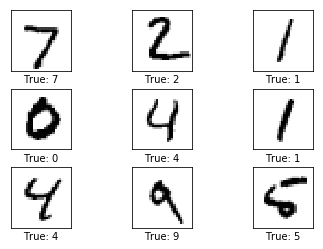

In [16]:
print(data.train.labels)

data.train.cls = np.array([label.argmax() for label in data.train.labels])
data.test.cls = np.array([label.argmax() for label in data.test.labels])

print(data.train.cls)

images = data.test.images[0:9]
cls_true = data.test.cls[0:9]

util.plot_images(images=images, img_shape=img_shape, cls_true=cls_true)

In [59]:
# MNIST images are 28*28 in size
img_size = 28
img_shape = (img_size, img_size)
img_size_flat = 28*28

# Number of colour channels for the images: 1 channel for gray-scale.
num_channels = 1
# Number of classes, one class for each of 10 digits.
num_classes = 10

# Model

In [60]:
# Convolutional Layer 1.
filter_size1 = 5          # Convolution filters are 5 x 5 pixels.
num_filters1 = 32         # There are 16 of these filters.

# Convolutional Layer 2.
filter_size2 = 5          # Convolution filters are 5 x 5 pixels.
num_filters2 = 64         # There are 36 of these filters.

# Fully-connected layer.
fc_size = 128             # Number of neurons in fully-connected layer.

In [82]:
# Input image. The size is 28*28=784, which is img_size_flat
x = tf.placeholder(tf.float32, shape=[None, img_size_flat], name='x')
y = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')
y_cls = tf.argmax(y_true, dimension=1)
keep_prob = tf.placeholder(tf.float32)
learning_rate = 0.01
dropout = 0.75

batch_size = 32

display_step = 100
training_iters = 100000

x_image = tf.reshape(x, [-1, 28, 28, 1])
print(x)
print(x_image)
print(keep_prob)

Tensor("x_15:0", shape=(?, 784), dtype=float32)
Tensor("Reshape_61:0", shape=(?, 28, 28, 1), dtype=float32)
Tensor("Placeholder_13:0", dtype=float32)


In [79]:
def conv2d(x, weights, biases, strides=1):
    x = tf.nn.conv2d(x, weights, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, biases)
    return tf.nn.relu(x)

def maxpool2d(x, k=2):
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1], padding='SAME')

def conv_net(x, weights, biases, dropout):
    x = tf.reshape(x, shape=([-1, img_size, img_size, 1]))
    
    # conv layer 1
    conv1 = conv2d(x, weights['wc1'], biases['bc1'])
    conv1 = maxpool2d(conv1, k=2)
    
    # conv layer 2
    conv2 = conv2d(conv1, weights['wc2'], biases['bc2'])
    conv2 = maxpool2d(conv2, k=2)
    
    # fully connected layer
    fc1 = tf.reshape(conv2, [-1, weights['wd1'].get_shape().as_list()[0]])
    fc1 = tf.add(tf.matmul(fc1, weights['wd1']), biases['bd1'])
    fc1 = tf.nn.relu(fc1)
    # Apply Dropout
    fc1 = tf.nn.dropout(fc1, dropout)

    # Output, class prediction
    out = tf.add(tf.matmul(fc1, weights['out']), biases['out'])
    return out

In [84]:
# Store layers weight & bias
weights = {
    # 5x5 conv, 1 input, 32 outputs
    'wc1': tf.Variable(tf.random_normal([5, 5, 1, 32])),
    # 5x5 conv, 32 inputs, 64 outputs
    'wc2': tf.Variable(tf.random_normal([5, 5, 32, 64])),
    # fully connected, 7*7*64 inputs, 1024 outputs
    'wd1': tf.Variable(tf.random_normal([7*7*64, 1024])),
    # 1024 inputs, 10 outputs (class prediction)
    'out': tf.Variable(tf.random_normal([1024, num_classes]))
}

biases = {
    'bc1': tf.Variable(tf.random_normal([32])),
    'bc2': tf.Variable(tf.random_normal([64])),
    'bd1': tf.Variable(tf.random_normal([1024])),
    'out': tf.Variable(tf.random_normal([num_classes]))
}

# Construct model
pred = conv_net(x, weights, biases, keep_prob)

# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# Evaluate model
correct_pred = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# Initializing the variables
init = tf.global_variables_initializer()

In [85]:
# Launch the graph

with tf.Session() as sess:
    sess.run(init)
    step = 1
    # Keep training until reach max iterations
    while step * batch_size < training_iters:
        batch_x, batch_y = data.train.next_batch(batch_size)
        # Run optimization op (backprop)
        sess.run(optimizer, feed_dict={x: batch_x, y: batch_y,
                                       keep_prob: dropout})
        if step % display_step == 0:
            # Calculate batch loss and accuracy
            loss, acc = sess.run([cost, accuracy], feed_dict={x: batch_x,
                                                              y: batch_y,
                                                              keep_prob: 1.})
            print("Iter " + str(step*batch_size) + ", Minibatch Loss= " + \
                  "{:.6f}".format(loss) + ", Training Accuracy= " + \
                  "{:.5f}".format(acc))
        step += 1
    print("Optimization Finished!")

    # Calculate accuracy for 256 mnist test images
    print("Testing Accuracy:", \
        sess.run(accuracy, feed_dict={x: data.test.images[:256],
                                      y: data.test.labels[:256],
                                      keep_prob: 1.}))

Iter 3200, Minibatch Loss= 341.422363, Training Accuracy= 0.81250
Iter 6400, Minibatch Loss= 112.302658, Training Accuracy= 0.90625
Iter 9600, Minibatch Loss= 135.322128, Training Accuracy= 0.93750
Iter 12800, Minibatch Loss= 34.130959, Training Accuracy= 0.93750
Iter 16000, Minibatch Loss= 87.089417, Training Accuracy= 0.90625
Iter 19200, Minibatch Loss= 9.699417, Training Accuracy= 0.96875
Iter 22400, Minibatch Loss= 13.439247, Training Accuracy= 0.96875
Iter 25600, Minibatch Loss= 60.595459, Training Accuracy= 0.96875
Iter 28800, Minibatch Loss= 222.713425, Training Accuracy= 0.90625
Iter 32000, Minibatch Loss= 0.000000, Training Accuracy= 1.00000
Iter 35200, Minibatch Loss= 22.445435, Training Accuracy= 0.96875
Iter 38400, Minibatch Loss= 20.038101, Training Accuracy= 0.96875
Iter 41600, Minibatch Loss= 0.000000, Training Accuracy= 1.00000
Iter 44800, Minibatch Loss= 62.101635, Training Accuracy= 0.93750
Iter 48000, Minibatch Loss= 0.000000, Training Accuracy= 1.00000
Iter 51200, M